In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
plt.style.use("ggplot")
sns.set_style("whitegrid")

In [2]:
data = pd.read_csv('../data/data.csv', index_col ='Date', parse_dates=True)

In [3]:
data = data['Close']
print(data)

Date
2010-03-30      8.423214
2010-03-31      8.392857
2010-04-01      8.427500
2010-04-05      8.517500
2010-04-06      8.555000
                 ...    
2024-03-19    176.080002
2024-03-20    178.669998
2024-03-21    171.369995
2024-03-22    172.279999
2024-03-25    170.850006
Name: Close, Length: 3521, dtype: float64


In [4]:
from statsmodels.tsa.stattools import adfuller

def adf_test(data):
    result = adfuller(data.values)
    print('ADF Statistics: %f' % result[0])
    print('p-value: %f' % result[1])
    print('num of lags: %f' % result[2])
    print('num of observations: %f' % result[3])
    print('Critical values:')
    for k, v in result[4].items():
        print('\t%s: %.3f' % (k,v))

print('ADF TEST RESULT')
adf_test(data)

ADF TEST RESULT
ADF Statistics: 0.136639
p-value: 0.968475
num of lags: 18.000000
num of observations: 3502.000000
Critical values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


pvalue > 0.05 이므로 귀무가설을 기각할 수 없다. 따라서 구글(알파벳) 주식 데이터 (data) 는 비정상성 데이터이다.

<Axes: xlabel='Date'>

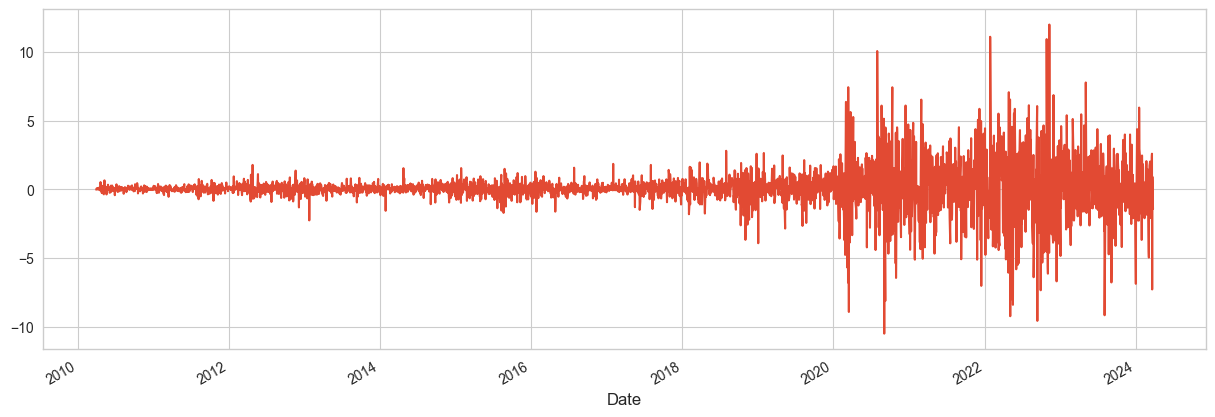

In [5]:
dff1 = data.diff().dropna()
dff1.plot(figsize=(15,5))

In [6]:
# 차분 테이터 adf테스트
print('ADF TEST RESULT')
adf_test(dff1)

ADF TEST RESULT
ADF Statistics: -13.690105
p-value: 0.000000
num of lags: 17.000000
num of observations: 3502.000000
Critical values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


해석> pvalue가 0.05미만이므로 가설 기각(채택), 1차 차분 처리한 데이터가 정상성 데이터가 되었다!
=> 비정상성 데이터는 차분을 이용하여 안정적으로 만들어 분석한다. (ARIMA)
결론 : 원본데이터는 비정상성 시계열 데이터이므로 차분을 이용하는 시계열 모형을 사용하자! = ARIMA를 사용하자~!

AR(p), 차분(d), MA(q)에서 보통 p+q <2, p*q=0 인 값을 많이 사용한다. (p,q둘 중 한 값이 0)
실제로는 AR 이나 MA 둘중 하나의 경향을 강하게 띄기 때문에 주로 이렇게 사용한다.

추정 방법은 (방법1)ACF plot과 PACF plot을 통해 모수 추정 하는 것과 (방법2)pmdarima 라이브러리의 ndiffs, auto_arima 함수를 사용하여 모수 추정하는 방법이 있다.

/Users/juwon/anaconda3/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


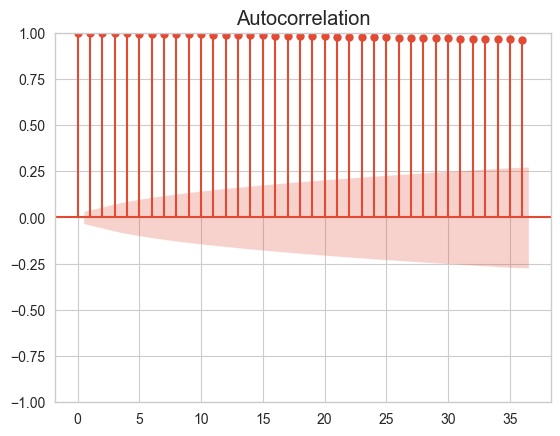

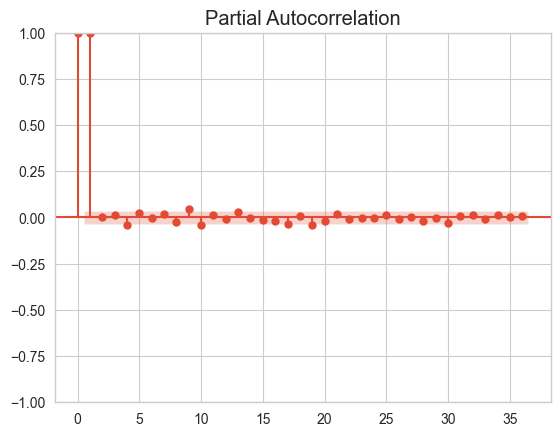

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data)
plot_pacf(data)
plt.show()

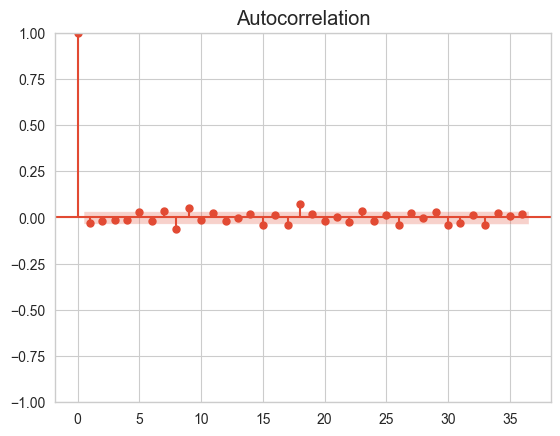

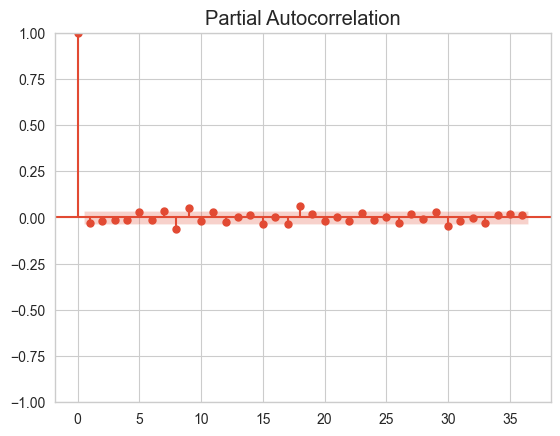

In [8]:
plot_acf(dff1)
plot_pacf(dff1)
plt.show()

In [9]:
import pmdarima as pm
from pmdarima.arima import ndiffs

n_diffs = ndiffs(data, alpha=0.05, test='adf', max_d=6)
print(f"Estimated d = {n_diffs}") 

Estimated d = 1


In [10]:
model = pm.auto_arima(
            y=data, 
            d=1, 
            start_p=0, max_p=3, 
            start_q=0, max_q=3, 
            m=1, seasonal=False, 
            stepwise=True,
            trace=True
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12867.947, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12867.323, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12867.213, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12869.258, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12867.480, Time=0.52 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=12867.768, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=12869.296, Time=0.49 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=12868.721, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.621 seconds


In [11]:
print(model.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3521
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -6430.607
Date:                Mon, 15 Apr 2024   AIC                          12867.213
Time:                        13:40:09   BIC                          12885.712
Sample:                             0   HQIC                         12873.814
                               - 3521                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0461      0.025      1.873      0.061      -0.002       0.094
ma.L1         -0.0284      0.008     -3.352      0.001      -0.045      -0.012
sigma2         2.2611      0.022    102.224      0.0

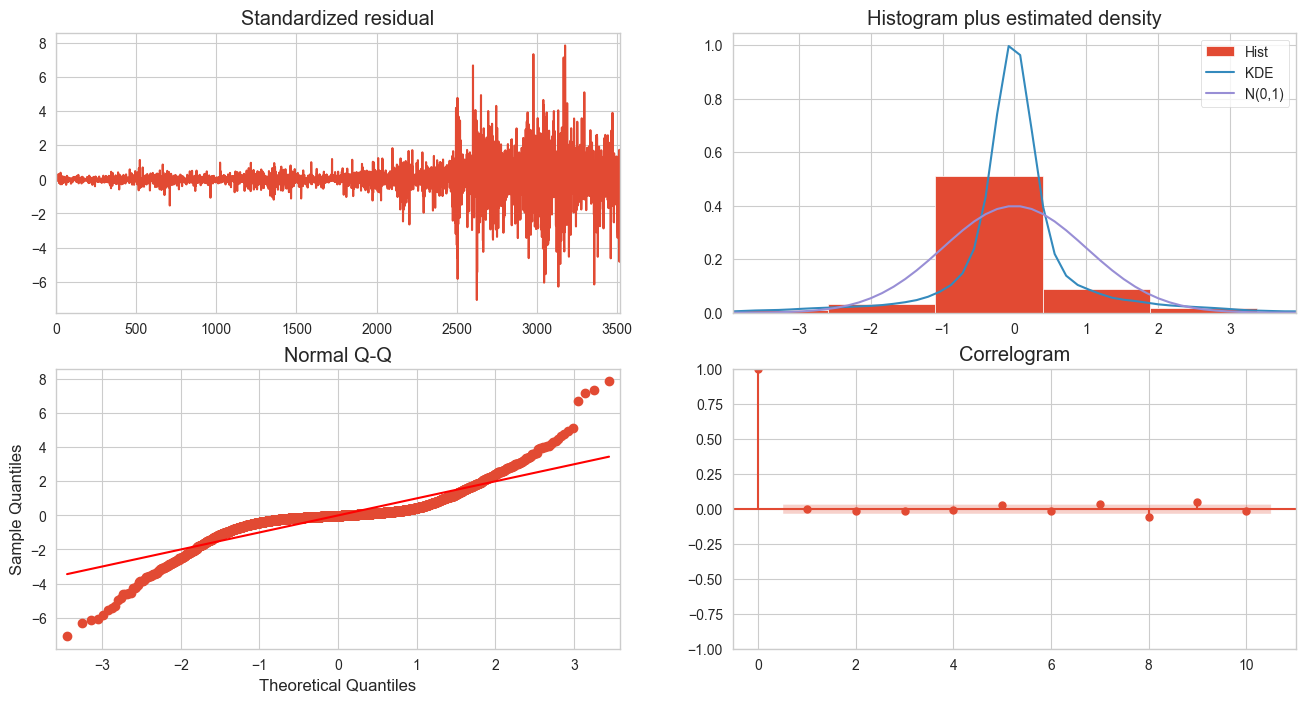

In [12]:
model.plot_diagnostics(figsize=(16,8))
plt.show()

결론: 잔차는 백색잡음(정상성)이지만, 정규성은 따르지 않는다. 따라서 추후 모형 설정에서 여러 파라미터(모수)들을 변경하거나 데이터를 변환해가며 모형을 테스트해본다.

In [13]:
train_data, test_data = data[:int(len(data)*0.8)], data[int(len(data)*0.8):]

In [14]:
from statsmodels.tsa.arima_model import ARIMA

model_fit = pm.auto_arima(
    	    y=train_data, 
 	        d=n_diffs , 
            start_p=0, max_p=2, 
            start_q=0, max_q=2, 
            m=1, seasonal=False, 
            stepwise=True,
            trace=True
)
print(model_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8060.469, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8026.343, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8028.236, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8063.250, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8026.744, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8026.098, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8030.137, Time=0.54 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8028.007, Time=0.38 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=8027.553, Time=0.23 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7973.685, Time=1.13 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=7976.714, Time=0.65 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 3.405 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2

In [15]:
# forecast 
def forecast_n_step(model, n = 1):
    fc, conf_int = model.predict(n_periods=n, return_conf_int=True)
    return (
        fc.tolist()[0:n], np.asarray(conf_int).tolist()[0:n]
   )

def forecast(len, model, index, data=None):
    y_pred = []
    pred_upper = []
    pred_lower = []

    if data is not None:
        for new_ob in data:
            fc, conf = forecast_n_step(model)
            y_pred.append(fc[0])
            pred_upper.append(conf[0][1])
            pred_lower.append(conf[0][0])
            model.update(new_ob)
    else:
        for i in range(len):
            fc, conf = forecast_n_step(model)
            y_pred.append(fc[0])
            pred_upper.append(conf[0][1])
            pred_lower.append(conf[0][0])
            model.update(fc[0])
    return pd.Series(y_pred, index=index), pred_upper, pred_lower

/Users/juwon/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


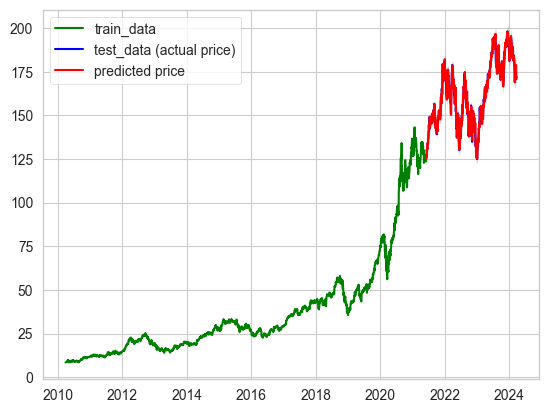

In [16]:
# Forecast 
fc, upper, lower = forecast(len(test_data), model_fit, test_data.index, data = test_data)

# pandas series 

lower_series = pd.Series(lower, index=test_data.index)  
upper_series = pd.Series(upper, index=test_data.index)  

# Plot
plt.plot(train_data, c='g', label='train_data')
plt.plot(test_data, c='b', label='test_data (actual price)')
plt.plot(fc, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend(loc='upper left')
plt.show()

<Figure size 1000x600 with 0 Axes>

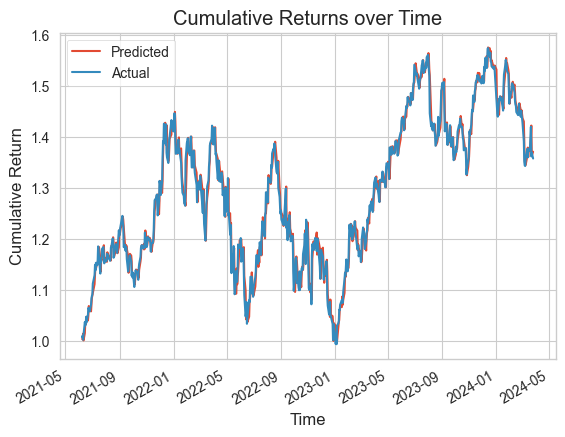

Predicted Final Cumulative Return: 1.3702607496014274
Actual Final Cumulative Return: 1.357029420435684


In [17]:
results_df = pd.DataFrame({
    'Predicted_Price': fc,
    'Actual_Price': test_data, 
})

results_df['Predicted_Return'] = results_df['Predicted_Price'].pct_change()
results_df['Actual_Return'] = results_df['Actual_Price'].pct_change()

results_df['Predicted_Cumulative_Return'] = (1 + results_df['Predicted_Return']).cumprod()
results_df['Actual_Cumulative_Return'] = (1 + results_df['Actual_Return']).cumprod()

plt.figure(figsize=(10, 6))
results_df[['Predicted_Cumulative_Return', 'Actual_Cumulative_Return']].plot()
plt.title('Cumulative Returns over Time')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.legend(['Predicted', 'Actual'])
plt.show()

predicted_final_return = results_df['Predicted_Cumulative_Return'].iloc[-1]
actual_final_return = results_df['Actual_Cumulative_Return'].iloc[-1]

print(f"Predicted Final Cumulative Return: {predicted_final_return}")
print(f"Actual Final Cumulative Return: {actual_final_return}")

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)
mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)


MSE:  2.5597515104458745e+169
MAE:  5.38977713436614e+83


In [19]:

sharpe_ratio = np.mean(results_df['Predicted_Return']) / np.std(results_df['Predicted_Return']) * np.sqrt(252.)

print(f"Sharpe Ratio: {sharpe_ratio}")


Sharpe Ratio: 0.5495840529269642
